In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# A Reinforcement Learning toy problem - visualized

Here, we study a typical toy problem that's often used for introductory courses. An actor finds herself in an environment represented by a board - a 2-dimensional grid. The fields in that grid can have different characteristics, and in our case the characteristic is given by the reward $R$ associated with each field. We have regular fields with a small negative reward, meant to encourage the actor to look for the shortest path, and we have fields that come with great reward or great penalties. You'll see a graphical representation of that field in a minute, don't worry.

### Deterministic Moves
Here, a deterministic move is an action in the terminology of Reinforcement Learning. A deterministic move takes a state and returns a new one, namely the particular state where the actor has moved into the given direction. We'll introduce states hereafter. Moves can go into the 8 typical directions, with the 'none' move as a nineth option to not move at all.
We modelled moves as classes with a ```__call__()``` method to be able to actually apply a move to a state and return the state - the board - with the actor now sitting on a field adjacent to the previously occupied field.

In [0]:
class Move:
  @staticmethod
  def actions(include_none=False):
    all = {
        's': [0,-1], 'w': [-1,0], 'n': [0,1], 'e':[1,0],
        'ne': [1,1], 'nw': [-1,1], 'se': [1,-1], 'sw': [-1, -1]}
    if include_none:
      all['none'] = [0,0]
    return all
  

class DMove(Move):
  "Deterministic action"
  
  def __init__(self, dir):
    self.R=1-1j
    self.L=1+1j
    self.dir = Move.actions(include_none=True)[dir] if type(dir)==str else dir
    
  def __call__(self, state):
    return state.after(self)
    
  def compare(self, other):
    """
    basically the sign of the inner product
    """
    return np.sign(self.dir[0]*other.dir[0] + self.dir[1]*other.dir[1])
  
  def rot_left(self, n=1):
    return self.rot(self.L, n)
  
  def rot_right(self, n=1):
    return self.rot(self.R, n)
  
  def rot(self, A, n=1):
    D= complex(self.dir[0], self.dir[1])
    once = DMove([np.sign(np.real(A*D)), np.sign(np.imag(A*D))])
    return once if n==1 else once.rot(A, n-1)

  def __repr__(self):
    return str(self.dir)

We can already play around with the Moves without knowing the board - the state - yet. Noticed the use of complex numbers for rotation? Cool stuff, huh?

In [4]:
south = DMove('s')
south, south.rot_left() # from south to south-east.

([0, -1], [1.0, -1.0])

```compare()``` returns $1$ if the moves are somewhat parallel - $0$, if they're perpendicular and $-1$ if they're somewhat antiparallel. We'll use that feature to make the agents moves less *unmotivated*. We want her to avoid going back after she'd made a step into a certain direction. This behaviour will be encoded into her  policy $p(s,a)$ 

In [5]:
south.compare(south.rot_left(3))

-1.0

In [0]:
s, se, e, w = [DMove(i) for i in ['s', 'se', 'e', 'w']]

### The updateable Bellmann value function
We want to make the value function a part of the state, since its updates occur when the state changes as the result of a chosen action. That's why we need to have the value function defined first. We can call it on a state once we have states available. Observe that the value function actually just implements some kind of functional memory interface.

In [0]:
class ValueFn:
  def __init__(self):
    self.values={}

  @staticmethod
  def _hash(s):
    return np.shape(s.board)[0] * s.pos[0] + s.pos[1]
    
  def update(self, s, v):
    self.values[ValueFn._hash(s)] = v
    
  def __call__(self, s):
    return self.values.get(ValueFn._hash(s)) or 0.0
  
  def as_matrix(self, s):
    shape_b = np.shape(s.board)
    rows = shape_b[0]
    cols = shape_b[1]
    return [[self.values.get(r+c*rows) or 0.0 for c in range(cols)] for r in range(rows)]

---

### The State = the board


In [0]:
class State:
  def __init__(self, board, start, value_function=ValueFn(), gamma=0.9):
    self.board = board
    self.pos = np.array(start)
    self.top=np.shape(board)[0]
    self.right=np.shape(board)[1]
    self.la = DMove('none') # most recent action
    self.vf = value_function
    self.gamma = gamma
    
  def options(self): 
    """
    All actions that lead to fields with valid rewards
    """
    return [ a[0]
           for a in Move.actions(include_none=False).items()
          if not np.isnan(self.reward_at(a[1]))]
    
    
  def __repr__(self):
    import seaborn as sns

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

    sns.heatmap(self.vf.as_matrix(self), cmap='bwr_r', ax=ax2)
   
    axes = sns.heatmap(self.board, annot=True, cmap='bwr_r', ax=ax1, cbar=False)
    axes.plot([self.pos[0]+0.5], [self.top-self.pos[1]-0.5], 'go', markersize=40)
    d = 0.4/np.sqrt(self.la.dir[0]**2 + self.la.dir[1]**2)
    axes.plot([self.pos[0]+0.5+d*self.la.dir[0]], 
              [self.top-self.pos[1]-0.5+d*self.la.dir[1]], 
              'go', markersize=20)
    return ""

  
  def update_bv(self):
    self.vf.update(self, self.new_bv())
  
  
  def new_bv(self):
    """
    The new value according to the bellmann equation
    """
    return np.max([self.reward_at(DMove(a).dir) + 
     self.gamma * self.bv(DMove(a))
     for a in self.options()])  
  
  def bv(self, a):
    x, y = a.dir
    step=np.array([x,-y])
    pos1 = self.pos + step
    return self.vf.values.get(np.shape(self.board)[0] * pos1[0] + pos1[1]) or 0.0
  
  def after(self, m):
    import copy
    c = copy.deepcopy(self)
    x, y = m.dir
    step=np.array([x,-y])
    pos1 = c.pos + step
    if pos1[0] < 0 or pos1[0] >= c.right or pos1[1] < 0 or pos1[1] >= c.top:
      c.la = DMove('none')
      return c
    if np.isnan(board[pos1[1], pos1[0]]):
      c.la = DMove('none')
      return c
    else:
      c.la = m
      c.pos = pos1
      c.update_bv()
      return c
     

  def reward_at(self, step):
    pos1 = self.pos + np.array([step[0], -step[1]])
    if pos1[0] < 0 or pos1[0] >= self.right or pos1[1] < 0 or pos1[1] >= self.top:
      return np.nan
    if np.isnan(board[pos1[1], pos1[0]]):
      return np.nan
    else:
      return board[pos1[1], pos1[0]]
    

  def bellmann_value(self): # Bellmann value    
    return self.vf(self) # that's how we make the value function pluggable.
   
    
  def success(self):
    return self.reward_at([0,0]) == 1
   
    
  def failure(self):
    return self.reward_at([0,0]) == -1
  
  
  def is_done(self):
    return self.failure() or self.success()
      

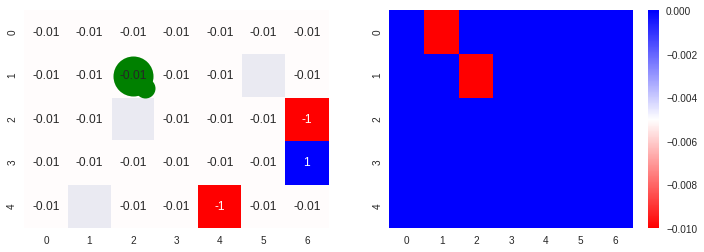

In [122]:
board = np.array([[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
       [-0.01, -0.01, -0.01, -0.01, -0.01, np.nan, -0.01],
       [-0.01, -0.01, np.nan, -0.01, -0.01, -0.01, -1],
       [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, 1],
       [-0.01, np.nan, -0.01, -0.01, -1, -0.01, -0.01]])


s0 = State(board, [0,0])
se(e(s0))

The grey areas are *forbidden*. The State class will simply ignore moves onto those fields - just as well as it will ignore moves that would lead beyond the limits of the board.

The state is considered done when the reward is either $1$ or $-1$

In [47]:
s0.options()

['s', 'e', 'se']

In [48]:
s0.is_done()

False

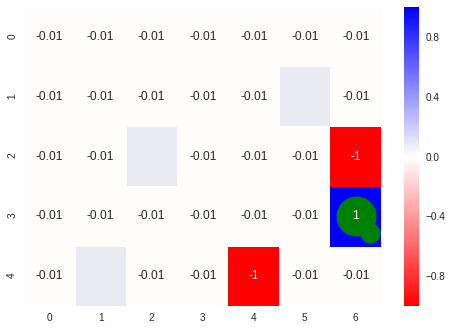

In [49]:
s1 = se(se(e(e(se(e(s0)))))) # Moving on to the maximum reward
s1

In [50]:
s1.is_done()

True

---
### The policy

In [0]:
class Policy_epsilon_off:
  """      
  This policy prefers the max reward, but allows epsilon probability for 
  each non-max-expecting action in the direction of the previous move
  """
  def __init__(self, ng=.1):
    self.ng = ng
    
  def __call__(self, s, include_none=False):
    # Look at the neighbours
    environ = { a[0]: s.reward_at(a[1]) for a in Move.actions(include_none).items()}
    # omit those going somewhat backwards
    environ={a[0]: a[1] if DMove(a[0]).compare(s.la) >= 0 else np.nan 
             for a in environ.items()} 
    return self.policy(environ)
  
  
  def policy(self, environ):
    # The number of possible directions
    lenr = len([i[1] for i in environ.items() if not np.isnan(i[1])])

    # The max return (maybe multiple)
    maxr = np.max([i[1] for i in environ.items() if not np.isnan(i[1])])

    # The number of values equal to the max
    lenm = len([i[1] for i in environ.items() 
                if not np.isnan(i[1]) and i[1]==maxr])
           
    pmax = (1 - (lenr-lenm) * self.ng) / lenm
    
    return { i[0]: pmax if i[1] == maxr else .1
            if not np.isnan(i[1]) else 0 
            for i in environ.items()}
  
  
  def draw(self, s, include_none=False):
    """
    Choose an action according to the given epsilon-greedy distribution
    """
    d = self.__call__(s, include_none)
    keys = ['s', 'w', 'e', 'n', 'se', 'ne', 'sw', 'nw']
    if include_none:
      keys.append('none')
    values = np.cumsum([ d[k] for k in keys])
    values = np.insert(values, 0,0)
    index = np.digitize(np.random.uniform(), values)-1
    return keys[index]

Our policy provides a distribution for choosing the next action somewhat *not-so-greedy*. It avoids going back. Observe that the last move below is going east, so our policy omits all options that have an western component. 

In [52]:
p = Policy_epsilon_off(.1)
e, w = [DMove(i) for i in ['e', 'w']]
s1 = e(w(w(s1)))
p(s1)

{'e': 0.6, 'n': 0.1, 'ne': 0.1, 'nw': 0, 's': 0.1, 'se': 0.1, 'sw': 0, 'w': 0}

You can see the policy in action if you draw from the distribution that it establishes:

In [53]:
p = Policy_epsilon_off(.1)
bins={'none': 0, 'n': 0, 'e': 0, 's': 0, 'w': 0, 'ne': 0, 'se': 0, 'sw': 0, 'nw': 0}
for i in range(10000):
  bins[p.draw(s1, include_none=False)]+=1
bins

{'e': 5935,
 'n': 1005,
 'ne': 1033,
 'none': 0,
 'nw': 0,
 's': 1054,
 'se': 973,
 'sw': 0,
 'w': 0}

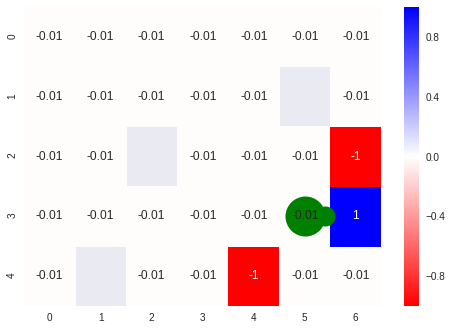

In [54]:
s1

---
### Bellmann equation for deterministic environments

$$
V(s)=\text{max}_a(R(s,a) + \gamma \cdot V(a(s))
$$

Note that the value of a state does not depend on the current policy. 

In [55]:
s1.reward_at([1, 0])

1.0

---
### An updatable ValueFunction for the board world

In [0]:
class ValueFn:
  def __init__(self):
    self.values={}

  @staticmethod
  def _hash(s):
    return np.shape(s.board)[0] * s.pos[0] + s.pos[1]
    
  def update(self, s, v):
    self.values[ValueFn._hash(s)] = v
    
  def __call__(self, s):
    return self.values.get(ValueFn._hash(s)) or 0.0
  
  def as_matrix(self, s):
    shape_b = np.shape(s.board)
    rows = shape_b[0]
    cols = shape_b[1]
    return [[self.values.get(r+c*rows) or 0.0 for c in range(cols)] for r in range(rows)]

In [84]:
v = ValueFn()
v.update(s1,5.0)
v(s1)

5.0

In [76]:
rows = 
[[v.values.get(r+c*5) or 0.0 for c in range(7)] for r in range(5)]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 5, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

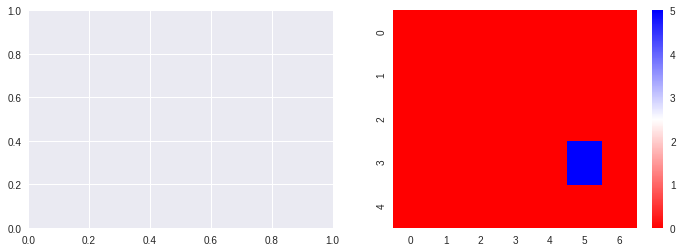

In [99]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))
sns.heatmap(v.as_matrix(s1), cmap='bwr_r', ax=ax2)

In [69]:
v._hash(s1)

38

In [70]:
s1.pos

array([5, 3])

In [72]:
np.shape(s1.board)[1]

7

From finance talk: Check the following (out of curiosity)

- Hurst exponents
- strange attractors
- Problem: markets change, so models will always be off-guard
- Black-Scholes learned by RL (paper!)
- Dynamich Replication and Hedging A Reinforcement Learning Approach
- Inverse RL: Find the utility function $v(s)$
- Watch: Alpha-go: The movie
- paper: Inverse Reinforcement Learning for Marketing
- Book: Big Data and ML in Quantitative Investment: Tony Guida